In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import os
from typing import Tuple
import numpy as np
import pickle
import cv2

In [ ]:
def load_generators_train(dataset_dir: str, image_dim: Tuple[int, int], batch_size: int):
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1./255)

    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        shuffle=True,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_dim,
        batch_size=batch_size)
    # it takes input images and outputs augmented images

    print('created dataset for {}'.format(dataset_dir))

    return train_generator

In [ ]:
def load_generators_val(dataset_dir: str, image_dim: Tuple[int, int], batch_size: int):
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        dataset_dir,
        shuffle=False,
        color_mode="rgb",
        class_mode="categorical",
        target_size=image_dim,
        batch_size=1)
    print('created dataset for {}'.format(dataset_dir))

    return train_generator

In [ ]:
BATCH_SIZE = 16
IMG_HEIGHT = 256
IMG_WIDTH = 256

train_dir = '/content/gdrive/MyDrive/augment_images/disease'
validation_dir = '/content/gdrive/MyDrive/leaf_resized/disease'

# load the data generators
train_datagen = load_generators_train(train_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)

validation_datagen = load_generators_val(validation_dir, (IMG_HEIGHT, IMG_WIDTH), BATCH_SIZE)
#These new datasets are new transformed images produced using ImageDataGenerator class required for transfer learning.

Found 4010 images belonging to 5 classes.
created dataset for /content/gdrive/MyDrive/augment_images/disease
Found 408 images belonging to 5 classes.
created dataset for /content/gdrive/MyDrive/leaf_resized/disease


In [ ]:
INCEPTIONV3_TFHUB = 'https://tfhub.dev/google/tf2-preview/inception_v3/feature_vector/4'
#Getting the InceptionV3 model

In [ ]:
input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)
num_classes = train_datagen.num_classes
#declaring the classes and input shape

# fetch the feature extractor from the tf_hub
feature_extractor = hub.KerasLayer(INCEPTIONV3_TFHUB, input_shape=input_shape)
#used to gather the transfer learning model

# make the feature extractor trainable
feature_extractor.trainable = True
# create the sequential model
model = tf.keras.Sequential([
    feature_extractor,
    #tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.0005))
])


model.summary()
#out = GlobalAveragePooling2D()(out)
#out = Dense(512, activation='relu')(out)
#out = Dense(512, activation='relu')(out)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 22,854,437
Trainable params: 22,820,005
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# print the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 22,854,437
Trainable params: 22,820,005
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
# compiling the model
model.compile(
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.003,momentum=0.9),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# training the model
history=model.fit(
    train_datagen,
    epochs=50,
    steps_per_epoch=train_datagen.samples//train_datagen.batch_size, validation_data=validation_datagen)

Epoch 1/50
250/250 [==============================] - 3108s 12s/step - loss: 0.8339 - accuracy: 0.7722 - val_loss: 0.5034 - val_accuracy: 0.9167
Epoch 2/50
250/250 [==============================] - 121s 485ms/step - loss: 0.3572 - accuracy: 0.9608 - val_loss: 0.5844 - val_accuracy: 0.8873
Epoch 3/50
250/250 [==============================] - 122s 487ms/step - loss: 0.3004 - accuracy: 0.9783 - val_loss: 0.6316 - val_accuracy: 0.8775
Epoch 4/50
250/250 [==============================] - 122s 487ms/step - loss: 0.2716 - accuracy: 0.9887 - val_loss: 0.4774 - val_accuracy: 0.9461
Epoch 5/50
250/250 [==============================] - 122s 487ms/step - loss: 0.2777 - accuracy: 0.9876 - val_loss: 0.4840 - val_accuracy: 0.9338
Epoch 6/50
250/250 [==============================] - 122s 486ms/step - loss: 0.2685 - accuracy: 0.9882 - val_loss: 0.5292 - val_accuracy: 0.9167
Epoch 7/50
250/250 [==============================] - 121s 486ms/step - loss: 0.2542 - accuracy: 0.9945 - val_loss: 0.4291 - 

In [ ]:
name = 'model2'
print("[INFO] Saving model")
model.save('/content/gdrive/MyDrive/saved_models_inc/'+ name)

[INFO] Saving model
INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/saved_models_inc/model2/assets


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/saved_models_inc/model2/assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/gdrive/MyDrive/saved_models_inc/model1')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 22,854,437
Trainable params: 22,820,005
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
import os
from typing import Tuple

In [ ]:
import os
os.listdir("/content/gdrive/MyDrive/augment_images")

['disease']

In [ ]:
EPOCHS = 10
INIT_LR = 1e-3
BS = 16
default_image_size = tuple((256,256))
image_size = 0
directory_root = '/content/gdrive/MyDrive/augment_images'
width=256
height=256
depth=3

In [ ]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")

            for image in plant_disease_image_list[:800]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error --- : {e}")

[INFO] Loading images ...
[INFO] Processing cercospora ...
[INFO] Processing miner ...
[INFO] Processing rust ...
[INFO] Processing healthy ...
[INFO] Processing phoma ...
[INFO] Image loading completed


In [ ]:
image_size = len(image_list)
image_size

4000

In [ ]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['cercospora' 'healthy' 'miner' 'phoma' 'rust']


In [ ]:
np_image_list = np.array(image_list, dtype=np.float16) / 255.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [ ]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [ ]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=20, verbose=1
    )

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/20
152/200 [=====================>........] - ETA: 12s - loss: 0.4313 - accuracy: 0.9371

In [ ]:
# evaluate the model
loss, accuracy = model.evaluate(validation_datagen)
# train accuracy
train_loss, train_accuracy = model.evaluate(train_datagen)

251/251 [==============================] - 15s 58ms/step - loss: 0.2313 - accuracy: 1.0000


In [ ]:
len(train_datagen.index_array)

4010

In [ ]:
from keras.models import Model
model_feat = Model(inputs=model.input, outputs=model.get_layer('dense').output)
feat_train = model_feat.predict(train_datagen)

In [ ]:
model_feat.summary()
#print(feat_train.shape)
#feat_train.all

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_input (InputLaye [(None, 256, 256, 3)]     0         
_________________________________________________________________
keras_layer (KerasLayer)     (None, 2048)              21802784  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1049088   
Total params: 22,851,872
Trainable params: 22,817,440
Non-trainable params: 34,432
_________________________________________________________________


In [ ]:
predicted_class_indices=np.argmax(feat_train,axis=1)

predicted_class_indices

In [ ]:
print(train_datagen.class_indices)
print(train_datagen.labels)

{'cercospora': 0, 'healthy': 1, 'miner': 2, 'phoma': 3, 'rust': 4}
[0 0 0 ... 4 4 4]


# XGBoost

In [ ]:
import xgboost as xgb

xb = xgb.XGBClassifier(objective='multi:softprob', 
                      num_class= 5)
#xb.fit()

xb.fit(feat_train, train_datagen.labels)

print('fitting done !!!')

fitting done !!!


In [ ]:
y_pred = xb.predict(validation_datagen)

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
matrix=confusion_matrix(validation_datagen.classes, y_pred)
print(matrix)

In [ ]:
xb.score(feat_train, train_datagen.labels)

0.5942643391521197

In [ ]:
feat_val = model_feat.predict(validation_datagen)

In [ ]:
xb.fit(feat_val, validation_datagen.labels)
xb.score(feat_val, validation_datagen.labels)

1.0

In [ ]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.4, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], y=X[y == cl, 1],
                    alpha=0.8, c=cmap(idx),
                    marker=markers[idx], label=cl)

In [ ]:
plot_decision_regions(feat_val, validation_datagen.labels, xb)

# Random Forest Classifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rclf = RandomForestClassifier(n_estimators=30, min_samples_leaf=10, min_samples_split=10, max_features=0.5 ,n_jobs=-1)

In [ ]:
rclf.fit(feat_val, validation_datagen.labels)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features=0.5,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=-1,
                       oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix
y_pred = rclf.predict(validation_datagen)
print(len(validation_datagen.class_indices))

print(accuracy_score(validation_datagen.class_indices, y_pred))
print(recall_score(validation_datagen.class_indices, y_pred))
print(confusion_matrix(validation_datagen.class_indices, y_pred))

# Decision Tree Classifier

In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(feat_train, train_datagen.labels)

#Predict the response for test dataset
y_pred = clf.predict(validation_datagen)

In [ ]:
y_pred

array([4, 4, 1, 0, 0, 3, 0, 1, 2, 1, 2, 3, 2, 2, 0, 0, 1, 4, 4, 2, 1, 2,
       1, 4, 2, 4, 1, 1, 1, 1, 2, 4, 0, 0, 0, 4, 3, 4, 3, 3, 2, 1, 0, 4,
       2, 0, 2, 3, 2, 1, 0, 1, 1, 0, 1, 3, 0, 0, 3, 4, 4, 4, 1, 3, 1, 4,
       0, 3, 1, 0, 0, 0, 0, 4, 1, 0, 3, 0, 0, 1, 4, 1, 4, 1, 1, 4, 0, 0,
       3, 1, 3, 4, 4, 2, 2, 1, 3, 1, 2, 4, 0, 4, 3, 1, 0, 2, 0, 0, 3, 4,
       2, 2, 1, 2, 3, 0, 4, 0, 1, 2, 2, 4, 0, 2, 0, 2, 4, 1, 0, 4, 3, 4,
       4, 0, 4, 1, 3, 4, 4, 2, 1, 2, 2, 2, 2, 3, 3, 4, 2, 4, 2, 4, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 3, 1, 3, 4, 0, 0, 1, 1, 2, 1, 3, 4, 1, 0, 2,
       0, 0, 4, 3, 3, 3, 1, 2, 2, 2, 3, 2, 0, 2, 1, 1, 4, 1, 4, 3, 4, 0,
       3, 2, 4, 2, 1, 1, 0, 2, 4, 3, 2, 4, 3, 2, 2, 1, 2, 2, 4, 4, 1, 0,
       1, 4, 0, 3, 4, 0, 2, 4, 3, 2, 0, 4, 1, 1, 2, 1, 1, 1, 2, 4, 4, 2,
       0, 0, 4, 2, 4, 2, 1, 4, 3, 2, 1, 2, 1, 0, 2, 0, 0, 1, 2, 1, 2, 2,
       1, 0, 0, 0, 0, 0, 4, 3, 0, 0, 3, 0, 4, 3, 3, 1, 2, 3, 0, 4, 0, 0,
       0, 2, 2, 2, 0, 2, 0, 4, 3, 2, 3, 1, 1, 1, 3,

In [ ]:
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation
from sklearn.metrics import accuracy_score

#print("Accuracy:", metrics.accuracy_score(y_test, feat_val))
#print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(y_test, y_pred_gini)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(validation_datagen.labels, y_pred)))

Training-set accuracy score: 0.1814


In [ ]:
x_pred = clf.predict(feat_train)
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(train_datagen.labels, x_pred)))

Training-set accuracy score: 0.9980


In [ ]:
from sklearn.tree import DecisionTreeClassifier

# instantiate the DecisionTreeClassifier model with criterion gini index

clf_gini = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)

clf_gini.fit(train_datagen, train_datagen.labels)

y_pred_gini = clf_gini.predict(feat_val)

In [ ]:
from sklearn.metrics import accuracy_score

print('Model accuracy score with criterion gini index: {0:0.4f}'. format(accuracy_score(validation_datagen.labels, y_pred_gini)))
print('Training-set accuracy score: {0:0.4f}'. format(accuracy_score(train_datagen.labels, y_pred_train_gini)))

# Gaussian Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB 
gnbmodel = GaussianNB().fit(feat_train, train_datagen.labels) 

#submission_gnb = gnbmodel.predict(validation_datagen) 
gnbmodel.score(feat_val, validation_datagen.labels)

0.06862745098039216

In [ ]:
"Trained Model for {} epochs, train accuracy: {:5.2f}%, test accuracy: {:5.2f}%".format(2, 100*train_accuracy, 100*accuracy)

'Trained Model for 2 epochs, train accuracy: 99.88%, test accuracy: 94.85%'

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import make_interp_spline, BSpline

def Res_Plot_Test_Save(name):
    print("[INFO] Plotting model accuracy and Loss")
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = np.array(range(1, 51))
    #epochs = np.array([1, 2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20])
    epochs_new = np.linspace(epochs.min(), epochs.max(), 200)
    acc = np.array(acc)
    spl = make_interp_spline(epochs, acc, k=3)
    y1_smooth = spl(epochs_new)
    val_acc = np.array(val_acc)
    spl = make_interp_spline(epochs, val_acc, k=3)
    y2_smooth = spl(epochs_new)
    
    #Train and validation accuracy
    #plt.plot(epochs, acc, 'b', label='Training accurarcy')
    #plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
    plt.plot(epochs_new, y1_smooth, 'c', label='Training accurarcy')
    plt.plot(epochs_new, y2_smooth, 'm', label='Validation accurarcy')
    plt.title('Training and Validation accurarcy')
    plt.legend()

    loss = np.array(loss)
    spl = make_interp_spline(epochs, loss, k=3)
    y1_smooth = spl(epochs_new)
    val_acc = np.array(val_loss)
    spl = make_interp_spline(epochs, val_loss, k=3)
    y2_smooth = spl(epochs_new)
    plt.figure()
    #Train and validation loss
    plt.plot(epochs_new, y1_smooth, 'c', label='Training loss')
    plt.plot(epochs_new, y2_smooth, 'm', label='Validation loss')
    plt.title('Training and Validation loss')
    plt.legend()
    plt.show()
    
    print("[INFO] Calculating model accuracy")
    scores = model.evaluate(validation_datagen)
    print(f"Test Accuracy: {scores[1]*100}")
    
    #print("[INFO] Saving model")
    #model.save('/content/drive/MyDrive/Model/classification_model/'+ name)

[INFO] Plotting model accuracy and Loss


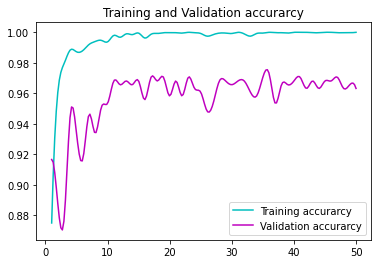

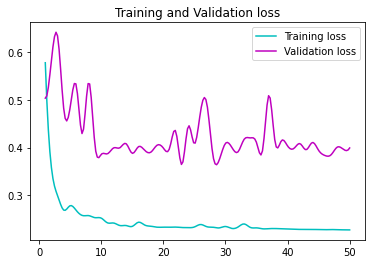

[INFO] Calculating model accuracy
408/408 [==============================] - 14s 33ms/step - loss: 0.3991 - accuracy: 0.9632
Test Accuracy: 96.32353186607361


In [ ]:
Res_Plot_Test_Save('penta_CNN_Algorithm.h5')

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np
Y_pred = model.predict(validation_datagen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
matrix=confusion_matrix(validation_datagen.classes, y_pred)
print(matrix)

Confusion Matrix
[[ 52   0   4   0   0]
 [  0  37   1   1   0]
 [  1   0  84   4   0]
 [  3   0   0  73   0]
 [  6   1   0   0 141]]


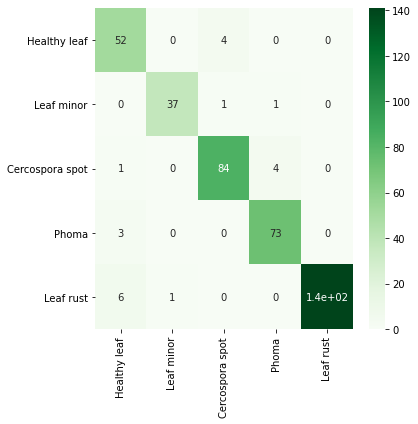

In [ ]:
import matplotlib.pyplot as plt 
labels=['Healthy leaf','Leaf minor','Cercospora spot','Phoma','Leaf rust']
import seaborn as sns
figure = plt.figure(figsize=(6, 6))
sns.heatmap(matrix,annot=True,cmap=plt.cm.Greens,xticklabels=labels,yticklabels=labels)
plt.tight_layout()
plt.show()